# Installing / Importing Libraries

In [1]:
import pandas as pd
from pandas import to_datetime
import numpy as np
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import HoltWintersResults
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
import time
from numpy import array
import string

In [2]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [4]:
Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)
Daily_data

,Inquiries_NonStat
date,
2017-01-01,7574.0
2017-01-02,13189.0
2017-01-03,24678.0
2017-01-04,23380.0
2017-01-05,22809.0
...,...
2022-09-26,13039.0
2022-09-27,11598.0
2022-09-28,11886.0


In [5]:
Daily_data.isna().any()

Inquiries_NonStat    False
dtype: bool

In [6]:
Daily_data.describe()

,Inquiries_NonStat
count,2099.000000
mean,14240.924250
std,5809.277724
min,406.000000
25%,9739.500000
50%,13864.000000
75%,19310.000000
max,30619.000000


<AxesSubplot: >

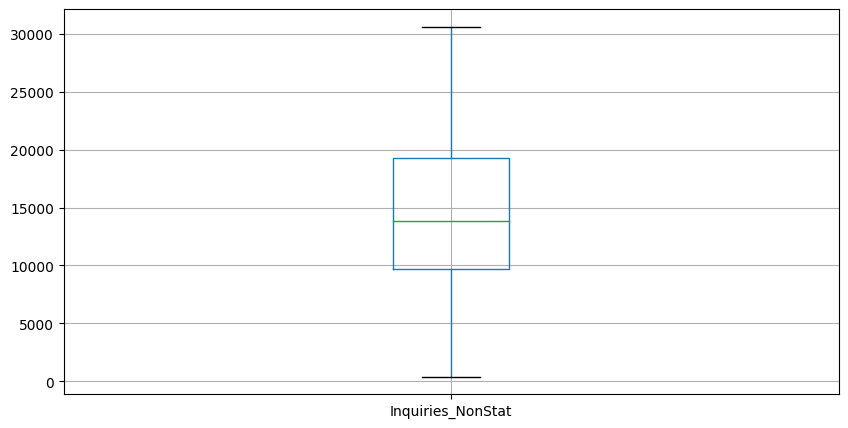

In [7]:
Daily_data.boxplot()

In [8]:
Daily_data.drop(Daily_data.columns.difference(['Inquiries_NonStat']),1, inplace=True)
Daily_data.plot()
Daily_data.rolling(window=30).mean()['Inquiries_NonStat'].plot()

C:\Users\manal\AppData\Local\Temp\ipykernel_51696\3351443599.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Daily_data.drop(Daily_data.columns.difference(['Inquiries_NonStat']),1, inplace=True)


<AxesSubplot: xlabel='date'>

In [9]:
Daily_data = Daily_data.reset_index('date')
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data = Daily_data.set_index('date')

# Splitting the data into 80:20 ratio

In [10]:
train_df = Daily_data.iloc[:1680]
test_df  = Daily_data.iloc[1679:]

In [11]:
train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

In [12]:
#%pip install tabulate

In [13]:
from tabulate import tabulate

# Create an empty table
table = []

# Add the column names
table.append(["Trend", "DampedT", "Seasonality", "SPeriods", "RemoveBias","Exog_var", "Steps", "RMSE"])

# Holt-Winters Model with different lead times & multisteps

## AIC score calculation

In [14]:
# AIC score calculating 
def score_model(history, config):
    t,d,s,p,r = config
    key = str(config)
    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    aic_score = float(model_fit.summary().tables[0].data[2][3])
	
    if aic_score is not None:
        print(' > ES Model[%s] %.3f' % (key, aic_score))
        return (key, aic_score) 

# grid search configs
def grid_search(data, cfg_list, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        tasks = (delayed(score_model)(data, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
        # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul']
    d_params = [True, False]
    s_params = ['add', 'mul']
    p_params = [7]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for r in r_params:
                        cfg = [t,d,s,p,r]
                        models.append(cfg)
    return models

data = Daily_data
# data split
n_test = 1679 # 20% testing
    # model configs
cfg_list = exp_smoothing_configs()

#steps=1

# grid search
scores = grid_search(data, cfg_list)
print('done')
    # list top 1 configs
print('Top 3 model scores:')
for cfg, aic_score in scores[:3]:
    
    print('> ES Model[%s] %.3f' % (cfg, aic_score))
print('Done')

 > ES Model[['add', True, 'add', 7, True]] 32270.169
 > ES Model[['add', True, 'add', 7, False]] 32270.169
 > ES Model[['add', True, 'mul', 7, True]] 32168.641
 > ES Model[['add', True, 'mul', 7, False]] 32168.641
 > ES Model[['add', False, 'add', 7, True]] 32278.251
 > ES Model[['add', False, 'add', 7, False]] 32278.251
 > ES Model[['add', False, 'mul', 7, True]] 32193.037
 > ES Model[['add', False, 'mul', 7, False]] 32193.037
 > ES Model[['mul', True, 'add', 7, True]] 32269.465
 > ES Model[['mul', True, 'add', 7, False]] 32269.465
 > ES Model[['mul', True, 'mul', 7, True]] 32168.097
 > ES Model[['mul', True, 'mul', 7, False]] 32168.097
 > ES Model[['mul', False, 'add', 7, True]] 32278.243
 > ES Model[['mul', False, 'add', 7, False]] 32278.243
 > ES Model[['mul', False, 'mul', 7, True]] 32175.562
 > ES Model[['mul', False, 'mul', 7, False]] 32175.562
done
Top 3 model scores:
> ES Model[['mul', True, 'mul', 7, True]] 32168.097
> ES Model[['mul', True, 'mul', 7, False]] 32168.097
> ES M

## ES Model[['mul', True, 'mul', 7, True]] 32168.097

### Lead time = 0 & 1-step ahead predictions

In [15]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=1
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['1steps_Preds'] = predictions

RMSEsteps_1 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_1])
RMSEsteps_1

Done


906.6218475993817

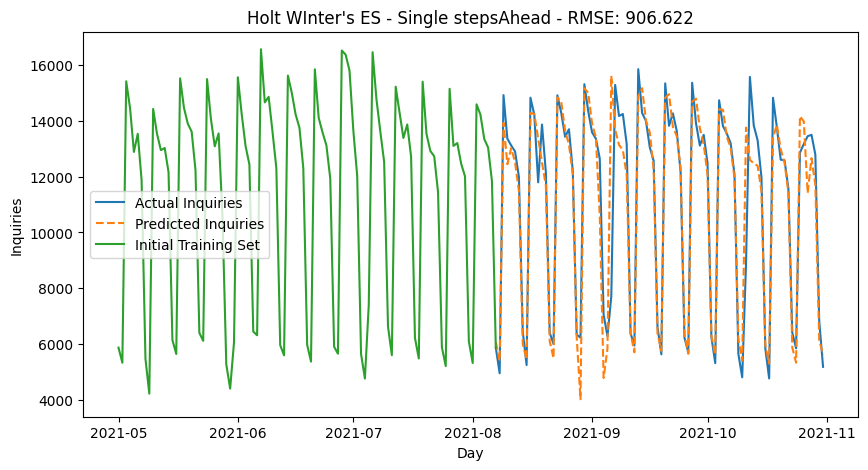

In [52]:
title = ''.join('Holt WInter\'s ES - Single stepsAhead - RMSE: '+str(np.round(RMSEsteps_1,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['1steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 2-step ahead ES predictions

In [17]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=2
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['2steps_Preds'] = predictions
RMSEsteps_2 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_2])
RMSEsteps_2

Done


1039.322616542081

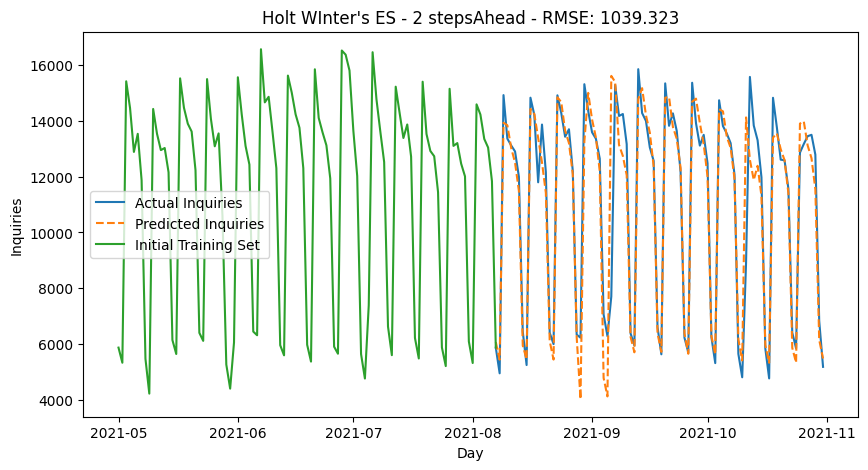

In [18]:
title = ''.join('Holt WInter\'s ES - 2 stepsAhead - RMSE: '+str(np.round(RMSEsteps_2,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['2steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 3-step ahead ES predictions

In [19]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=3
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['3steps_Preds'] = predictions
RMSEsteps_3 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_3])
RMSEsteps_3

Done


1140.1930359431312

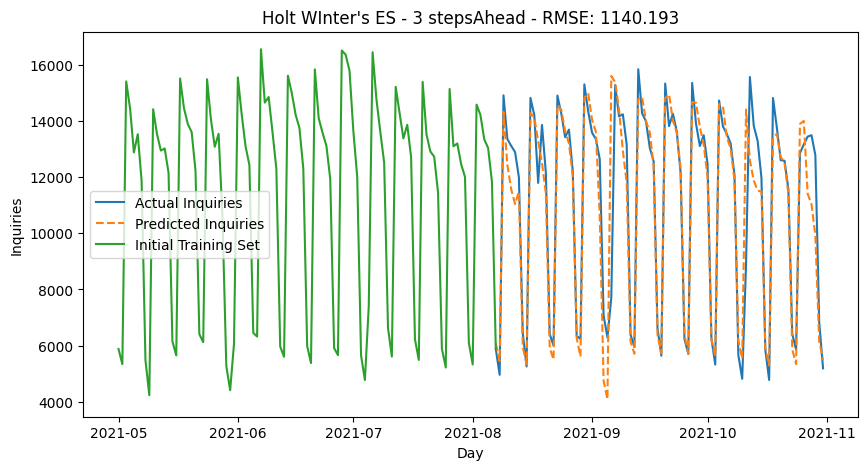

In [20]:
title = ''.join('Holt WInter\'s ES - 3 stepsAhead - RMSE: '+str(np.round(RMSEsteps_3,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['3steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 4-step ahead ES predictions

In [21]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=4
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['4steps_Preds'] = predictions
RMSEsteps_4 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_4])
RMSEsteps_4

Done


1142.1965258038103

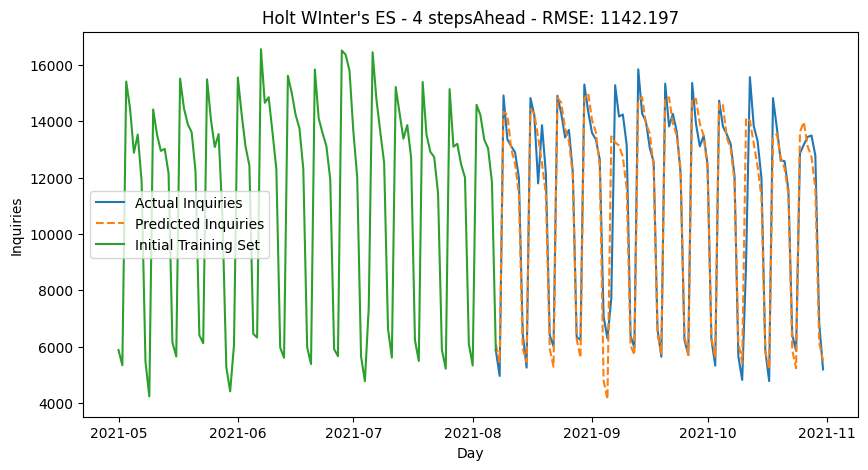

In [22]:
title = ''.join('Holt WInter\'s ES - 4 stepsAhead - RMSE: '+str(np.round(RMSEsteps_4,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['4steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 5-step ahead ES predictions

In [23]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=5
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['5steps_Preds'] = predictions
RMSEsteps_5 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_5])
RMSEsteps_5

Done


1115.4256241612902

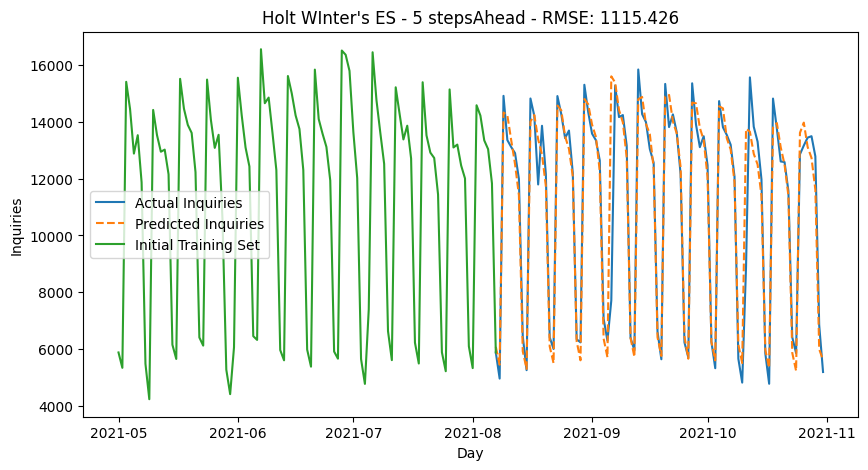

In [24]:
title = ''.join('Holt WInter\'s ES - 5 stepsAhead - RMSE: '+str(np.round(RMSEsteps_5,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['5steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 6-step ahead ES predictions

In [25]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=6
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['6steps_Preds'] = predictions
RMSEsteps_6 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_6])
RMSEsteps_6

Done


1196.1650306696963

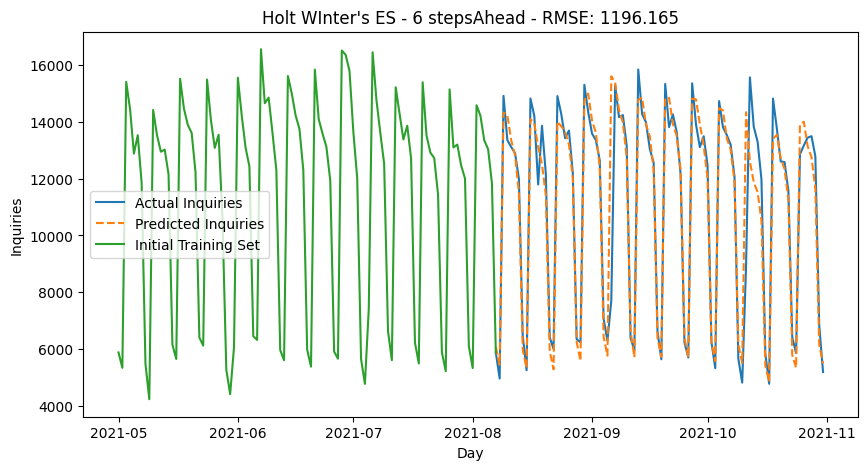

In [26]:
title = ''.join('Holt WInter\'s ES - 6 stepsAhead - RMSE: '+str(np.round(RMSEsteps_6,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['6steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 7-step ahead ES predictions

In [27]:
def exponential_forecasting(history, config, steps):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
    
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps)
        predictions = np.concatenate((predictions, yhat), axis=None)
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = sqrt(mean_squared_error(test[j:i], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = np.concatenate((train, test[j:i]), axis=None)
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=7
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions,rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['7steps_Preds'] = predictions
RMSEsteps_7 = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"No", steps, RMSEsteps_7])
RMSEsteps_7

Done


1146.073865607053

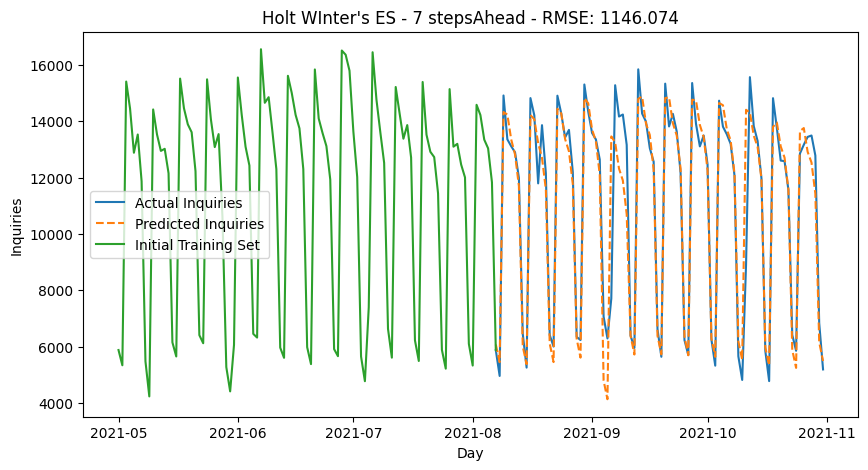

In [28]:
title = ''.join('Holt WInter\'s ES - 7 stepsAhead - RMSE: '+str(np.round(RMSEsteps_7,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['7steps_Preds'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

# Evaluating Prediction

## Scores with No exogenous variables

In [29]:
print(tabulate(table))

-----  -------  -----------  --------  ----------  --------  -----  ------------------
Trend  DampedT  Seasonality  SPeriods  RemoveBias  Exog_var  Steps  RMSE
mul    True     mul          7         True        No        1      906.6218475993817
mul    True     mul          7         True        No        2      1039.322616542081
mul    True     mul          7         True        No        3      1140.1930359431312
mul    True     mul          7         True        No        4      1142.1965258038103
mul    True     mul          7         True        No        5      1115.4256241612902
mul    True     mul          7         True        No        6      1196.1650306696963
mul    True     mul          7         True        No        7      1146.073865607053
-----  -------  -----------  --------  ----------  --------  -----  ------------------


In [30]:
table1 = tabulate(table)
with open('Exponential_Smoothing.txt', 'w') as f:
    f.write(str(table1) + '\n')
    f.close

In [31]:
Scores = []
Scores = pd.DataFrame(Scores)
Scores['Steps_Ahead'] = [1,2,3,4,5,6,7]
Scores['RMSE_ES'] = [RMSEsteps_1,RMSEsteps_2,RMSEsteps_3,
RMSEsteps_4,RMSEsteps_5,RMSEsteps_6,RMSEsteps_7]
Scores

,Steps_Ahead,RMSE_ES
0,1,906.621848
1,2,1039.322617
2,3,1140.193036
3,4,1142.196526
4,5,1115.425624
5,6,1196.165031
6,7,1146.073866


In [32]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_ES'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='ES_No_X',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
        #mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='purple', width=2)
    ))

fig.update_traces(texttemplate='%{text:.2s}')
#fig.update_layout(legend_title_text='Parameters',title_text='SARIMAX - RMSE for different steps ahead')
# strip down the rest of the plot
fig.update_layout(
    showlegend=True,
    plot_bgcolor="rgb(240,240,240)",
    margin=dict(t=50,l=10,b=10,r=10),
    title_text='ES - RMSE graph for different steps ahead',
    title_font_family="Times New Roman",
    title_font_size = 25,
    title_font_color="darkblue",
    title_x=0.5,
    xaxis=dict(
        title='Steps Ahead',tickfont_size=12,
        tickangle = 0,
        showgrid = True,
        zeroline = True,
        showline = True,
        showticklabels = True,
        dtick=1
    ),
    yaxis=dict(
        title='Error',
        titlefont_size=12,
        tickangle = 0,
        showticklabels = True,
        tickfont_size=12
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    bargap=0.15
)
fig.show()

# Holt-Winters Model with different lead times & multisteps - Exogenous variable(Holiday)

In [33]:
import holidays

df=Daily_data
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
# Create a DataFrame of holidays

nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019,2020,2021,2022])
holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.set_index(['date'])

# Join the holidays DataFrame with the original DataFrame
df = df.join(holidays_df, on='date')
df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)
df

,Inquiries_NonStat,holiday
date,,
2017-01-01,7574.0,1.0
2017-01-02,13189.0,1.0
2017-01-03,24678.0,0.0
2017-01-04,23380.0,0.0
2017-01-05,22809.0,0.0
...,...,...
2022-09-26,13039.0,0.0
2022-09-27,11598.0,0.0
2022-09-28,11886.0,0.0


## AIC score calculation

In [34]:
# AIC score calculating 
def score_model(train, config):
    t,d,s,p,r = config
    key = str(config)
    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    aic_score = float(model_fit.summary().tables[0].data[2][3])
	
    if aic_score is not None:
        print(' > ES Model[%s] %.3f' % (key, aic_score))
        return (key, aic_score) 

# grid search configs
def grid_search(data, cfg_list, parallel=False):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        tasks = (delayed(score_model)(data, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
        # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul']
    d_params = [True, False]
    s_params = ['add', 'mul']
    p_params = [7]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for r in r_params:
                        cfg = [t,d,s,p,r]
                        models.append(cfg)
    return models

data = df
# data split
n_test = 1679 # 20% testing
    # model configs
cfg_list = exp_smoothing_configs()

#steps=1

# grid search
scores = grid_search(data, cfg_list)
print('done')
    # list top 1 configs
print('Top 3 model scores:')
for cfg, aic_score in scores[:3]:
    
    print('> ES Model[%s] %.3f' % (cfg, aic_score))
print('Done')

 > ES Model[['add', True, 'add', 7, True]] 32270.169
 > ES Model[['add', True, 'add', 7, False]] 32270.169
 > ES Model[['add', True, 'mul', 7, True]] 32168.641
 > ES Model[['add', True, 'mul', 7, False]] 32168.641
 > ES Model[['add', False, 'add', 7, True]] 32278.251
 > ES Model[['add', False, 'add', 7, False]] 32278.251
 > ES Model[['add', False, 'mul', 7, True]] 32193.037
 > ES Model[['add', False, 'mul', 7, False]] 32193.037
 > ES Model[['mul', True, 'add', 7, True]] 32269.465
 > ES Model[['mul', True, 'add', 7, False]] 32269.465
 > ES Model[['mul', True, 'mul', 7, True]] 32168.097
 > ES Model[['mul', True, 'mul', 7, False]] 32168.097
 > ES Model[['mul', False, 'add', 7, True]] 32278.243
 > ES Model[['mul', False, 'add', 7, False]] 32278.243
 > ES Model[['mul', False, 'mul', 7, True]] 32175.562
 > ES Model[['mul', False, 'mul', 7, False]] 32175.562
done
Top 3 model scores:
> ES Model[['mul', True, 'mul', 7, True]] 32168.097
> ES Model[['mul', True, 'mul', 7, False]] 32168.097
> ES M

## ES Model[['mul', True, 'mul', 7, True]] 32168.097

### Lead time = 0 & 1-step ahead predictions

In [35]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=1
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['1steps_ES_X_Holidays'] = predictions
ES_1_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_1_X_Holidays_rmse])
ES_1_X_Holidays_rmse

Done


906.6218475993817

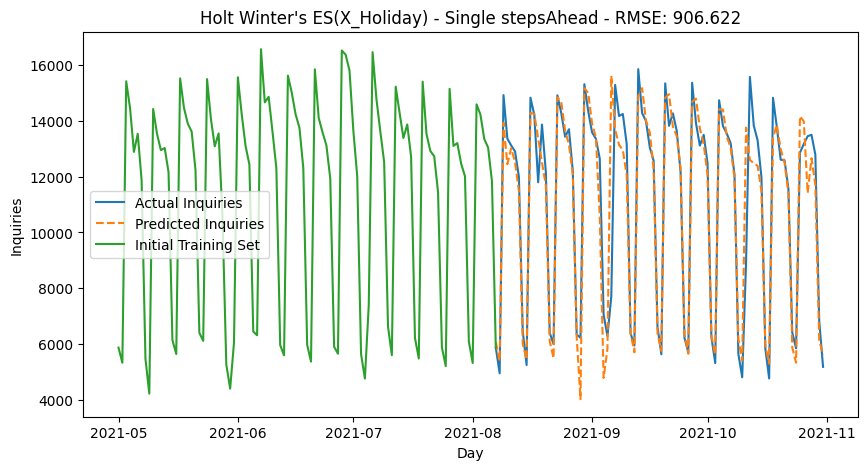

In [36]:
title = ''.join('Holt Winter\'s ES(X_Holiday) - Single stepsAhead - RMSE: '+str(np.round(ES_1_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['1steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 2-step ahead ES (X_Holiday) predictions

In [37]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=2
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['2steps_ES_X_Holidays'] = predictions
ES_2_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_2_X_Holidays_rmse])
ES_2_X_Holidays_rmse

Done


1039.322616542081

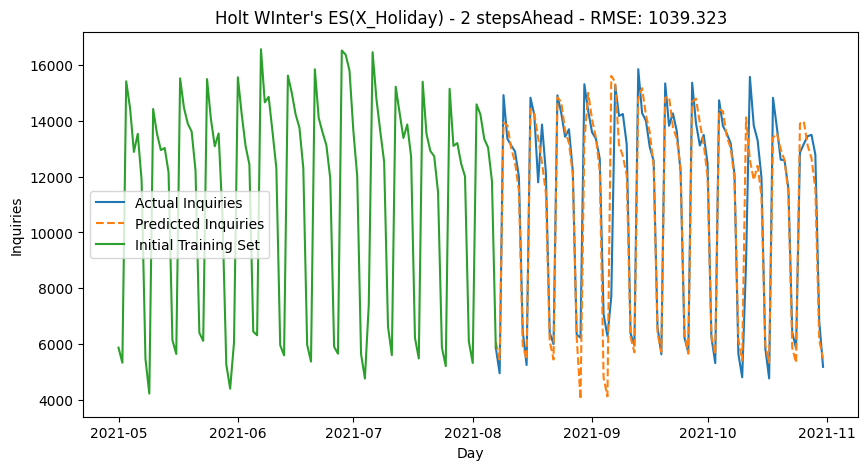

In [38]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 2 stepsAhead - RMSE: '+str(np.round(ES_2_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['2steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 3-step ahead ES (X_Holiday) predictions

In [39]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=3
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['3steps_ES_X_Holidays'] = predictions
ES_3_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_3_X_Holidays_rmse])
ES_3_X_Holidays_rmse

Done


1140.1930359431312

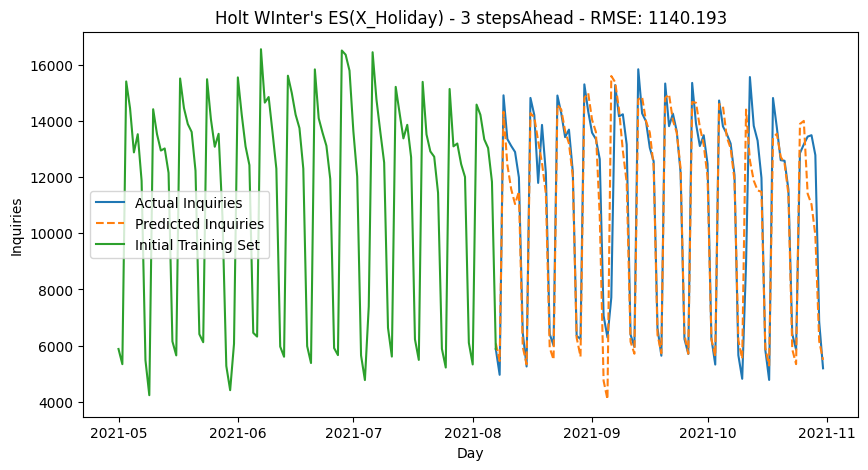

In [40]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 3 stepsAhead - RMSE: '+str(np.round(ES_3_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['3steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 4-step ahead ES (X_Holiday) predictions

In [41]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=4
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['4steps_ES_X_Holidays'] = predictions
ES_4_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_4_X_Holidays_rmse])
ES_4_X_Holidays_rmse

Done


1142.1965258038103

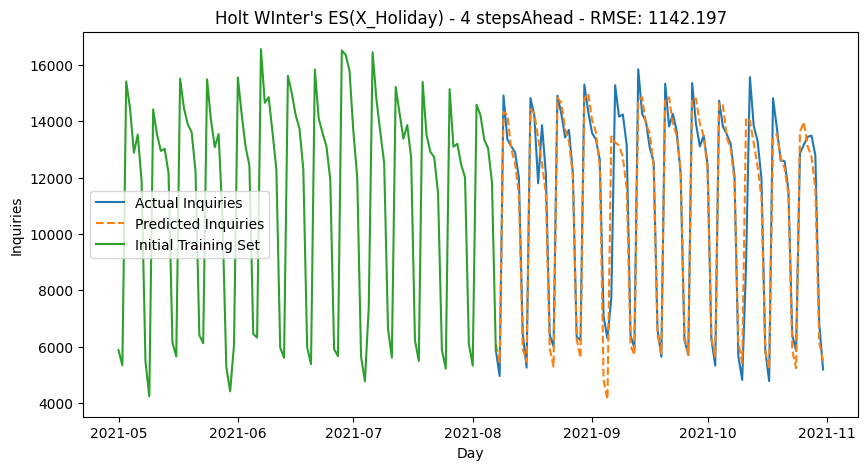

In [42]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 4 stepsAhead - RMSE: '+str(np.round(ES_4_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['4steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 5-step ahead ES (X_Holiday) predictions

In [43]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=5
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['5steps_ES_X_Holidays'] = predictions
ES_5_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_5_X_Holidays_rmse])
ES_5_X_Holidays_rmse

Done


1115.4256241612902

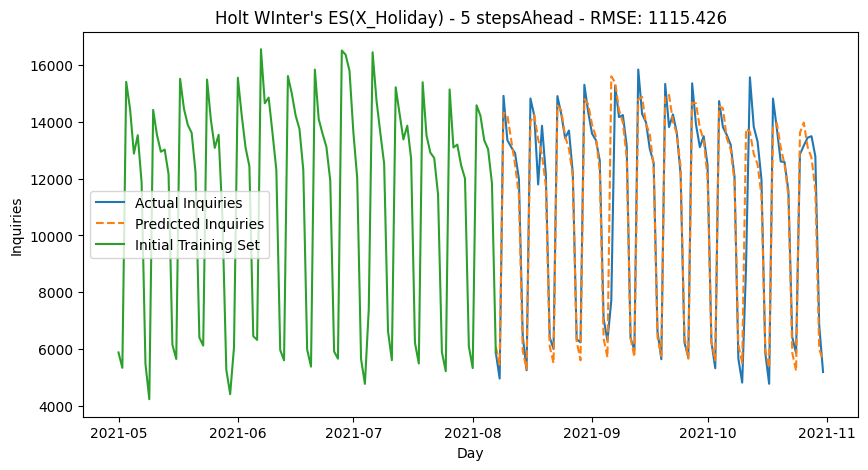

In [44]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 5 stepsAhead - RMSE: '+str(np.round(ES_5_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['5steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 6-step ahead ES (X_Holiday) predictions

In [45]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=6
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['6steps_ES_X_Holidays'] = predictions
ES_6_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_6_X_Holidays_rmse])
ES_6_X_Holidays_rmse

Done


1196.1650306696963

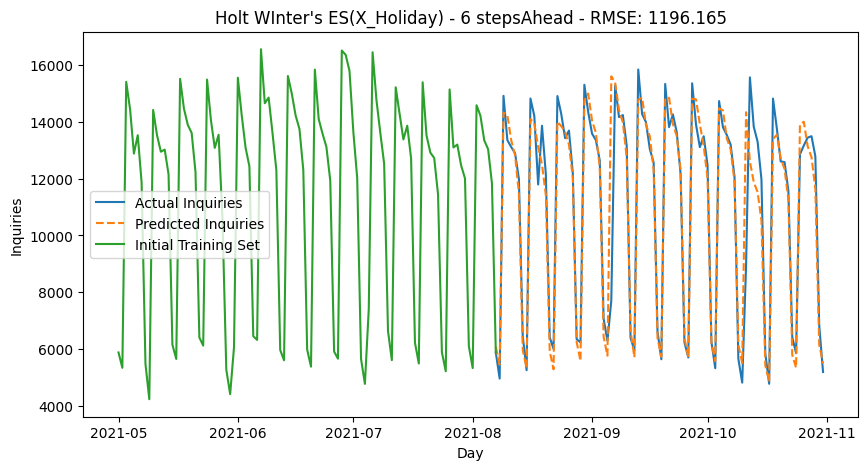

In [46]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 6 stepsAhead - RMSE: '+str(np.round(ES_6_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['6steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

### 7-step ahead ES (X_Holiday) predictions

In [47]:
def exponential_forecasting(train, config, steps, exog_forecast):
    t,d,s,p,r = config
    p=int(config[3])
    s= config[2].strip()

    # define model
    filterwarnings("ignore")
    model = ExponentialSmoothing(train[['Inquiries_NonStat']], trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model.exog = train[['holiday']]
	# fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    forecast = model_fit.forecast(steps = steps)
	# store forecast in list of predictions
    return forecast

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg,steps):
    predictions = np.array([])
    rmse_list = []
    # split dataset
    train, test = data[:n_test], data[n_test:]
    
    #day_list = [steps*x for x in range(1,3+1)]
    day_list = [steps*x for x in range(1,int(len(test_df)/steps+1))]
    # step over each time-step in the test set
    for i in day_list:
        exog_forecast = test[i-steps:i][['holiday']]
        # fit model and make forecast for history
        yhat = exponential_forecasting(train, cfg,steps, exog_forecast)
        predictions= np.concatenate((predictions,yhat))
        
        # store forecast in list of predictions
        j = i-steps

        rmse_score = math.sqrt(mean_squared_error(test[j:i]['Inquiries_NonStat'], predictions[j:i]))
        rmse_list.append(rmse_score)
        train = pd.concat([train, test[j:i]])
        # estimate prediction error
    return predictions, rmse_list


# data split
n_test = 1679 # 20% testing

steps=7
# list top 1 configs
cfg = ['mul', True, 'mul', 7, True]
predictions, rmse_list = walk_forward_validation(data, n_test, cfg,steps)
print('Done')

test_df['7steps_ES_X_Holidays'] = predictions
ES_7_X_Holidays_rmse = np.mean(rmse_list)
table.append([cfg[0], cfg[1], cfg[2], cfg[3], cfg[4],"Holidays", steps, ES_7_X_Holidays_rmse])
ES_7_X_Holidays_rmse

Done


1146.073865607053

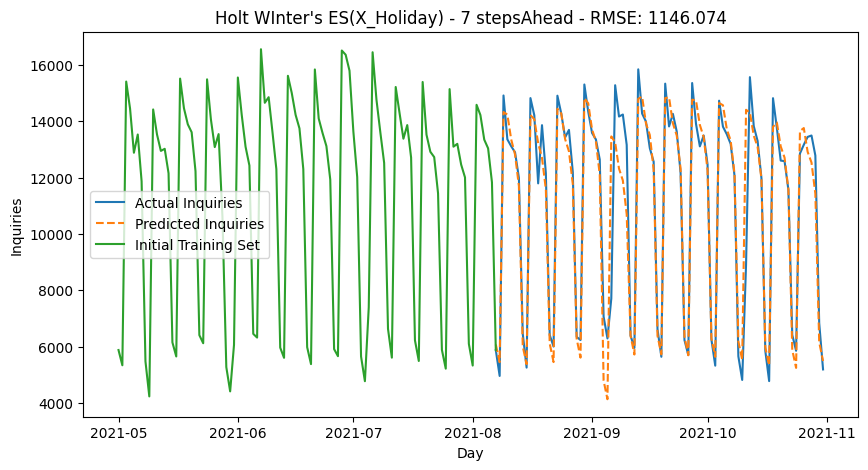

In [48]:
title = ''.join('Holt WInter\'s ES(X_Holiday) - 7 stepsAhead - RMSE: '+str(np.round(ES_7_X_Holidays_rmse,3)))

plt.title(title)
plt.plot(test_df.loc[:'2021-10-31']['Inquiries_NonStat'], label = 'Actual Inquiries')
plt.plot(test_df.loc[:'2021-10-31']['7steps_ES_X_Holidays'], '--', label = 'Predicted Inquiries')
plt.plot(train_df['2021-05-01':], label = 'Initial Training Set')
plt.xlabel('Day')
plt.ylabel('Inquiries')
plt.legend()
plt.show()

# Scores with Holidays exogenous variables

In [49]:
## Scores with Holidays exogenous variables
print(tabulate(table))
table2 = tabulate(table)
with open('Exponential_Smoothing2.txt', 'w') as f:
    f.write(str(table2) + '\n')
    f.close

-----  -------  -----------  --------  ----------  --------  -----  ------------------
Trend  DampedT  Seasonality  SPeriods  RemoveBias  Exog_var  Steps  RMSE
mul    True     mul          7         True        No        1      906.6218475993817
mul    True     mul          7         True        No        2      1039.322616542081
mul    True     mul          7         True        No        3      1140.1930359431312
mul    True     mul          7         True        No        4      1142.1965258038103
mul    True     mul          7         True        No        5      1115.4256241612902
mul    True     mul          7         True        No        6      1196.1650306696963
mul    True     mul          7         True        No        7      1146.073865607053
mul    True     mul          7         True        Holidays  1      906.6218475993817
mul    True     mul          7         True        Holidays  2      1039.322616542081
mul    True     mul          7         True        Holidays  3

In [50]:
Scores = []
Scores = pd.DataFrame(Scores)
Scores['Steps_Ahead'] = [1,2,3,4,5,6,7]
Scores['RMSE_ES'] = [RMSEsteps_1,RMSEsteps_2,RMSEsteps_3,
RMSEsteps_4,RMSEsteps_5,RMSEsteps_6,RMSEsteps_7]
Scores['RMSE_ES_X(Holidays)'] = [ES_1_X_Holidays_rmse,ES_2_X_Holidays_rmse,ES_3_X_Holidays_rmse,
ES_4_X_Holidays_rmse,ES_5_X_Holidays_rmse,ES_6_X_Holidays_rmse,ES_7_X_Holidays_rmse]
Scores

,Steps_Ahead,RMSE_ES,RMSE_ES_X(Holidays)
0,1,906.621848,906.621848
1,2,1039.322617,1039.322617
2,3,1140.193036,1140.193036
3,4,1142.196526,1142.196526
4,5,1115.425624,1115.425624
5,6,1196.165031,1196.165031
6,7,1146.073866,1146.073866


In [51]:


import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_ES'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='ES_No_X',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
        #mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='purple', width=2)
    ))

fig.add_trace(
    go.Scatter(
        x=Scores['Steps_Ahead'],
        y=Scores['RMSE_ES_X(Holidays)'],
        #,	'RMSE_SARIMA_Holidays',	'RMSE_SARIMA_X_All']],
        name='ES_X_Holidays',#	'SARIMAX_Holidays',	'SARIMA_X_All'],
        mode='lines+markers', 
        #mode = 'lines'
        marker= dict(size=5,
                     symbol = 'diamond',
                     #color ='RGB(251, 177, 36)',
                     line_width = 1
                   ),
        line = dict(color='forestgreen', width=2)
    ))
fig.update_traces(texttemplate='%{text:.2s}')
#fig.update_layout(legend_title_text='Parameters',title_text='SARIMAX - RMSE for different steps ahead')
# strip down the rest of the plot
fig.update_layout(
    showlegend=True,
    plot_bgcolor="rgb(240,240,240)",
    margin=dict(t=50,l=10,b=10,r=10),
    title_text='ES - RMSE graph for different steps ahead',
    title_font_family="Times New Roman",
    title_font_size = 25,
    title_font_color="darkblue",
    title_x=0.5,
    xaxis=dict(
        title='Steps Ahead',tickfont_size=12,
        tickangle = 0,
        showgrid = True,
        zeroline = True,
        showline = True,
        showticklabels = True,
        dtick=1
    ),
    yaxis=dict(
        title='Error',
        titlefont_size=12,
        tickangle = 0,
        showticklabels = True,
        tickfont_size=12
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    bargap=0.15
)
fig.show()

In [1]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/04-notebooks/03-modeling/'
Scores.to_csv(path+'ES_Scores.csv', sep=',')

NameError: name 'Scores' is not defined